# XAUUSD Prediction Bot Analysis
This notebook visualizes the data, training process, and **Future Predictions** for the Hybrid LSTM-ARIMA Model.

> **Make sure to run this in the virtual environment!**

In [27]:
# Ensure yfinance is installed in this notebook's environment\n
%pip install --upgrade yfinance --quiet

Note: you may need to restart the kernel to use updated packages.


In [28]:
# Reload module untuk mendapatkan versi terbaru
import importlib
import src.utils
importlib.reload(src.utils)
from src.utils import calculate_metrics

In [29]:

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Add source path
sys.path.append(os.path.abspath(''))

# Configure GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"[INFO] GPU Enabled: {len(gpus)} device(s)")
    except RuntimeError as e:
        print(e)

from src.data_loader import DataLoader
from src.hybrid_model import HybridModel
from src.utils import calculate_metrics, get_steps_for_days

[INFO] GPU Enabled: 1 device(s)


## 1. Configuration
**Change these values to customize your analysis.**

In [30]:
# --- CONFIGURATION --- #
SYMBOL = 'XAUUSD'       # Asset Symbol (e.g., 'XAUUSD', 'EURUSD')
TIMEFRAME = '15m'        # Timeframe: '1h', '30m', '15m', '4h', '1d'
PERIOD = '2y'           # History period to fetch: '1y', '2y', '5y', 'max'
FUTURE_DAYS = 5         # Number of days to predict into the future
EPOCHS = 20             # Training epochs
FUTURE_HOURS = 48  
# --------------------- #

## 2. Load Data

In [31]:
import os
print(f"Fetching {SYMBOL} data ({TIMEFRAME})...")
loader = DataLoader(symbol=SYMBOL, interval=TIMEFRAME, period=PERIOD, data_path=f'data/gold_{TIMEFRAME}.csv')

# Try to load from existing CSV first, then fetch fresh data
csv_path = f'data/gold_{TIMEFRAME}.csv'
if os.path.exists(csv_path):
    print(f"Loading from cached file: {csv_path}")
    df = loader.fetch_data(source='auto')  # Will load from CSV
else:
    try:
        df = loader.fetch_data(source='auto', force_download=True)
    except Exception as e:
        print(f"[ERROR] Live data fetch failed: {e}")
        print("Please ensure you have a working internet connection or provide a CSV file at:", csv_path)
        df = None

if df is not None and not df.empty:
    print(f"Loaded {len(df)} rows")
    display(df.tail())
else:
    print("ERROR: No data available. Cannot proceed.")


Fetching XAUUSD data (15m)...
Loading from cached file: data/gold_15m.csv
Loading data from data/gold_15m.csv
Loaded 4416 rows


,Open,High,Low,Close,Volume
Datetime,,,,,
2025-12-05 15:45:00-05:00,4231.100098,4232.000000,4229.000000,4231.600098,2156
2025-12-05 16:00:00-05:00,4231.399902,4231.700195,4229.100098,4229.899902,907
2025-12-05 16:15:00-05:00,4229.799805,4229.799805,4194.500000,4226.500000,1432
2025-12-05 16:30:00-05:00,4226.299805,4226.299805,4222.899902,4223.700195,740
2025-12-05 16:45:00-05:00,4223.799805,4228.700195,4197.600098,4212.899902,744


## 3. Preprocess

In [32]:
look_back = 60
X, y, scaled_data = loader.prepare_data_for_lstm(df, look_back=look_back)

# 80/20 Split for Validation
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Train samples: 3484, Test samples: 872


## 4. Train Hybrid Model

In [33]:
input_shape = (X.shape[1], X.shape[2])
model = HybridModel(input_shape)

print("Training...")
model.train(X_train, y_train, epochs=EPOCHS)

Training...
Training LSTM part...


/home/vanszs/Code/XAUUSD_Pred_Bot/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0101
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0023
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0021
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0016
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0010
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 9.9497e-04
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.6979e-04
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.9707e-04
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.9286e-04
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.8670e-04
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.7259e-04
Epoch 15/20
109/109

## 5. Evaluate (Test Set)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

=== Hybrid Model Evaluation (Paper Standard) ===
  MAE:       0.0104
  MSE:       0.0002
  RMSE:      0.0153
  MAPE:      1.7222%
  SMAPE:     1.7113%
  R²:        0.984792
  DA:        46.96%
  Max Error: 0.0969
  Accuracy:  98.28%


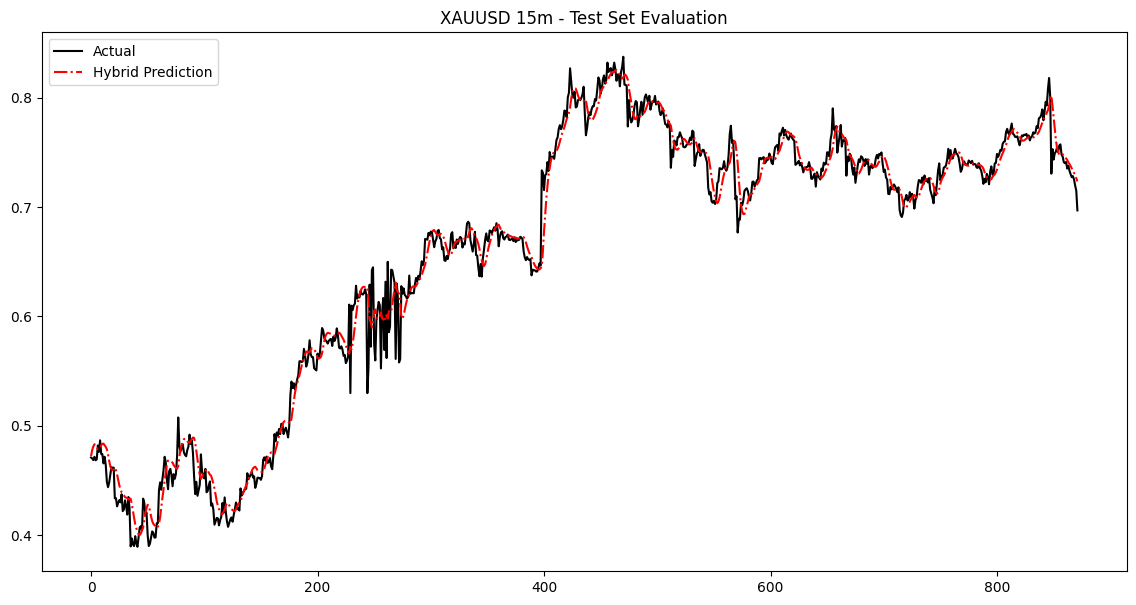

In [34]:
if 'model' not in locals():
    print("Error: 'model' is not defined. Please run the 'Train Hybrid Model' cell first.")
else:
    final_preds, lstm_preds, arima_preds = model.predict(X_test)
    
    metrics = calculate_metrics(y_test, final_preds)
    
    print("\n=== Hybrid Model Evaluation (Paper Standard) ===")
    print(f"  MAE:       {metrics['MAE']:.4f}")
    print(f"  MSE:       {metrics['MSE']:.4f}")
    print(f"  RMSE:      {metrics['RMSE']:.4f}")
    print(f"  MAPE:      {metrics['MAPE']:.4f}%")
    print(f"  SMAPE:     {metrics['SMAPE']:.4f}%")
    print(f"  R²:        {metrics['R2']:.6f}")
    print(f"  DA:        {metrics['DA']:.2f}%")
    print(f"  Max Error: {metrics['Max_Error']:.4f}")
    print(f"  Accuracy:  {metrics['Accuracy']:.2f}%")
    
    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(y_test, label="Actual", color='black')
    plt.plot(final_preds, label="Hybrid Prediction", color='red', linestyle='-.')
    plt.title(f"{SYMBOL} {TIMEFRAME} - Test Set Evaluation")
    plt.legend()
    plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


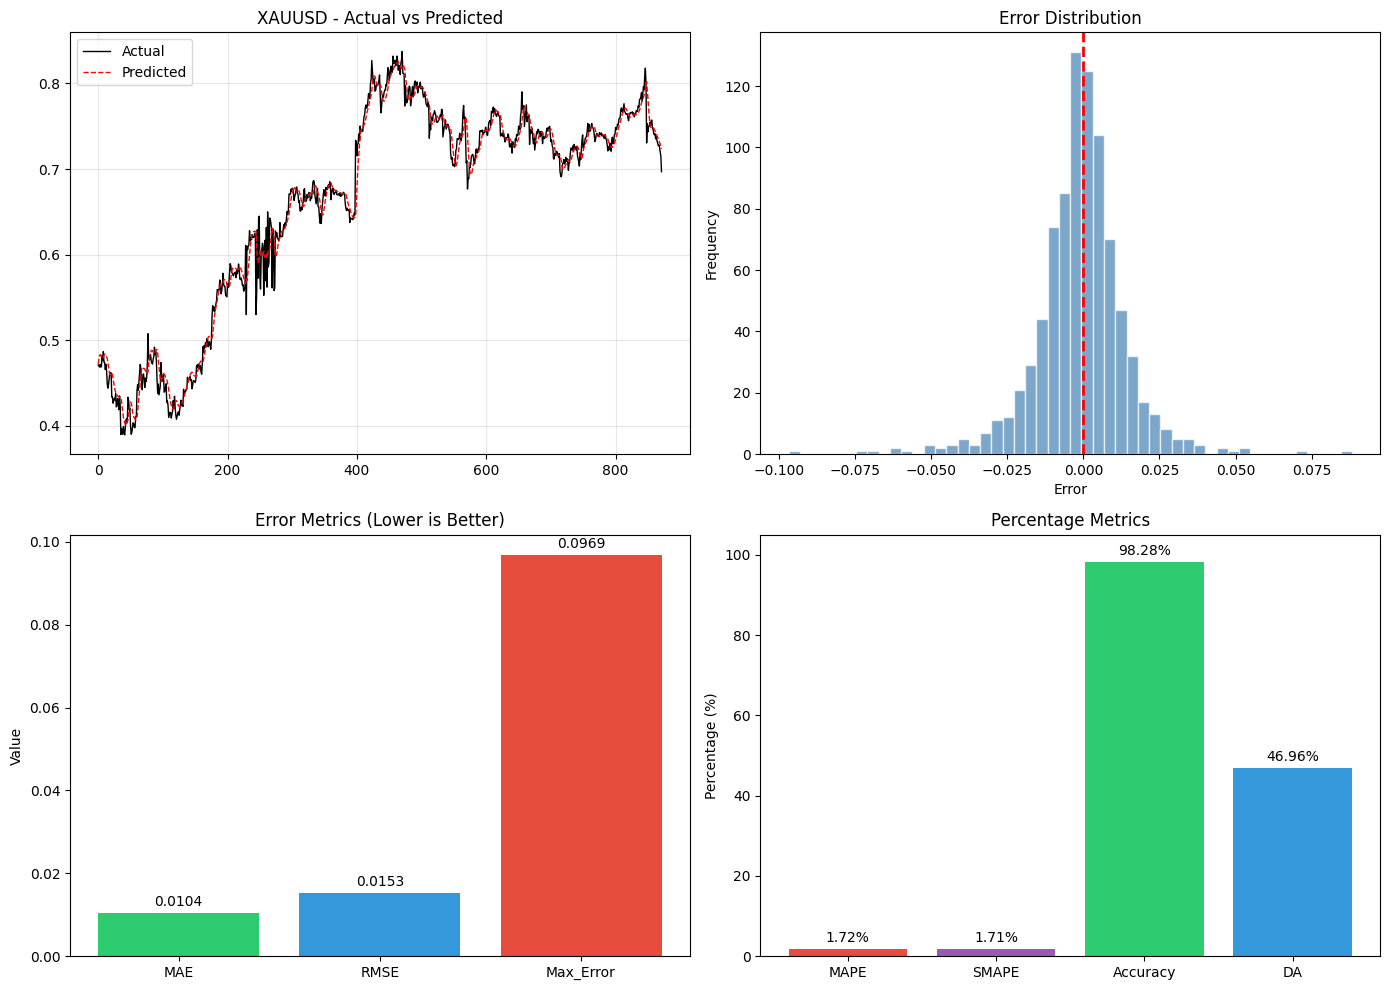


=== Summary ===
  R² Score: 0.984792
  Accuracy: 98.28%


In [37]:
# Reload module
import importlib
import src.utils
importlib.reload(src.utils)
from src.utils import calculate_metrics

if 'model' not in locals():
    print("Error: 'model' is not defined. Run training cell first.")
else:
    final_preds, lstm_preds, arima_preds = model.predict(X_test)
    metrics = calculate_metrics(y_test, final_preds)
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Actual vs Predicted
    axes[0, 0].plot(y_test, label="Actual", color='black', linewidth=1)
    axes[0, 0].plot(final_preds, label="Predicted", color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_title(f"{SYMBOL} - Actual vs Predicted")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Error Distribution (Histogram)
    errors = y_test.flatten() - final_preds.flatten()
    axes[0, 1].hist(errors, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_title("Error Distribution")
    axes[0, 1].set_xlabel("Error")
    axes[0, 1].set_ylabel("Frequency")
    
    # 3. Key Metrics Bar Chart
    key_metrics = ['MAE', 'RMSE', 'Max_Error']
    key_values = [metrics[k] for k in key_metrics]
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    bars = axes[1, 0].bar(key_metrics, key_values, color=colors)
    axes[1, 0].set_title("Error Metrics (Lower is Better)")
    axes[1, 0].set_ylabel("Value")
    for bar, val in zip(bars, key_values):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                        f'{val:.4f}', ha='center', va='bottom', fontsize=10)
    
    # 4. Percentage Metrics Bar Chart
    pct_metrics = ['MAPE', 'SMAPE', 'Accuracy', 'DA']
    pct_values = [metrics[k] for k in pct_metrics]
    colors = ['#e74c3c', '#9b59b6', '#2ecc71', '#3498db']
    bars = axes[1, 1].bar(pct_metrics, pct_values, color=colors)
    axes[1, 1].set_title("Percentage Metrics")
    axes[1, 1].set_ylabel("Percentage (%)")
    axes[1, 1].set_ylim(0, 105)
    for bar, val in zip(bars, pct_values):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                        f'{val:.2f}%', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print R² separately
    print(f"\n=== Summary ===")
    print(f"  R² Score: {metrics['R2']:.6f}")
    print(f"  Accuracy: {metrics['Accuracy']:.2f}%")

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_106336/4087961193.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_index = pd.date_range(start=last_time, periods=steps+1, freq=freq)[1:]


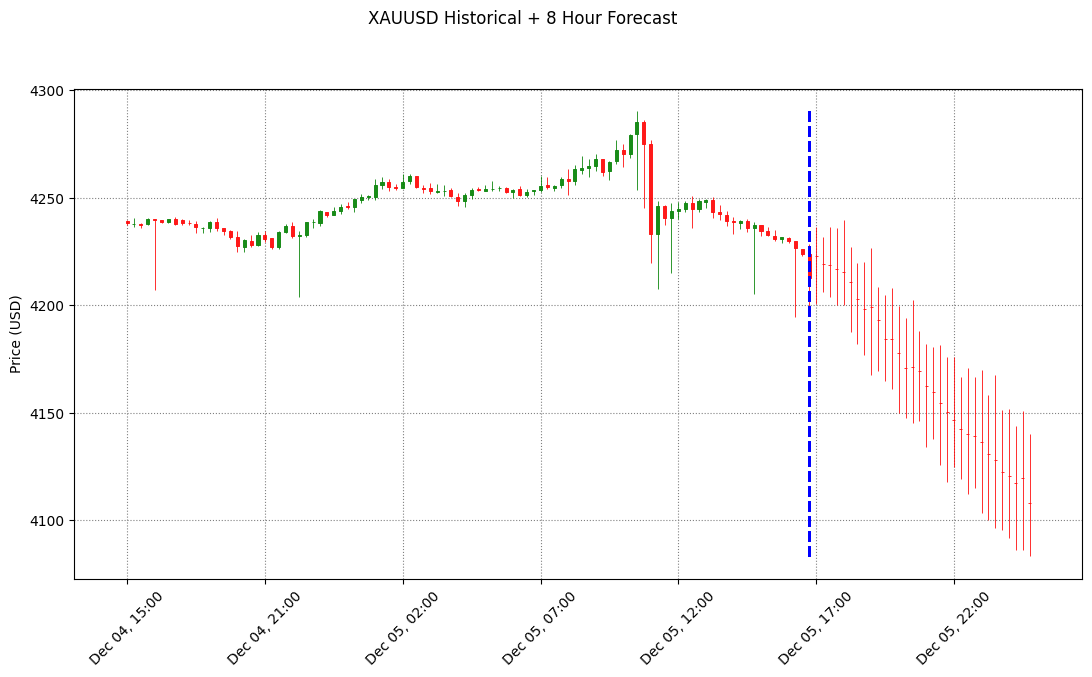


📍 Garis biru = titik mulai prediksi
📊 Candle sebelum garis = data aktual
📈 Candle setelah garis = prediksi (High/Low = confidence band)


In [38]:
# Install mplfinance jika belum ada
%pip install mplfinance --quiet

import mplfinance as mpf

# Ambil data OHLC terakhir dari DataFrame asli
history_length = 100
df_history = df.tail(history_length).copy()
df_history.index = pd.to_datetime(df_history.index)

# Buat prediksi dengan index waktu
last_time = df_history.index[-1]
freq = '15T' if TIMEFRAME == '15m' else '1H'  # 15 menit atau 1 jam
future_index = pd.date_range(start=last_time, periods=steps+1, freq=freq)[1:]

# DataFrame untuk prediksi (hanya Close, karena model hanya prediksi Close)
df_forecast = pd.DataFrame({
    'Open': mean_prices.flatten(),
    'High': upper_prices.flatten(),
    'Low': lower_prices.flatten(),
    'Close': mean_prices.flatten(),
    'Volume': 0
}, index=future_index)

# Gabungkan history + forecast
df_combined = pd.concat([df_history, df_forecast])

# Plot candlestick
mc = mpf.make_marketcolors(up='green', down='red', edge='inherit', wick='inherit')
style = mpf.make_mpf_style(marketcolors=mc, gridstyle=':', gridcolor='gray')

# Tambahkan garis vertikal sebagai penanda prediksi
vlines = dict(vlines=[last_time], linewidths=2, colors='blue', linestyle='--')

fig, axes = mpf.plot(
    df_combined,
    type='candle',
    style=style,
    title=f'{SYMBOL} Historical + {steps*15//60} Hour Forecast',
    ylabel='Price (USD)',
    volume=False,
    figsize=(14, 7),
    returnfig=True,
    vlines=vlines
)

plt.show()

print(f"\n📍 Garis biru = titik mulai prediksi")
print(f"📊 Candle sebelum garis = data aktual")
print(f"📈 Candle setelah garis = prediksi (High/Low = confidence band)")

## 6. Future Prediction

In [35]:
FUTURE_HOURS = 24  

Predicting 32 candles (8.0 hours) - Deterministic
Generating future prediction for 32 steps...


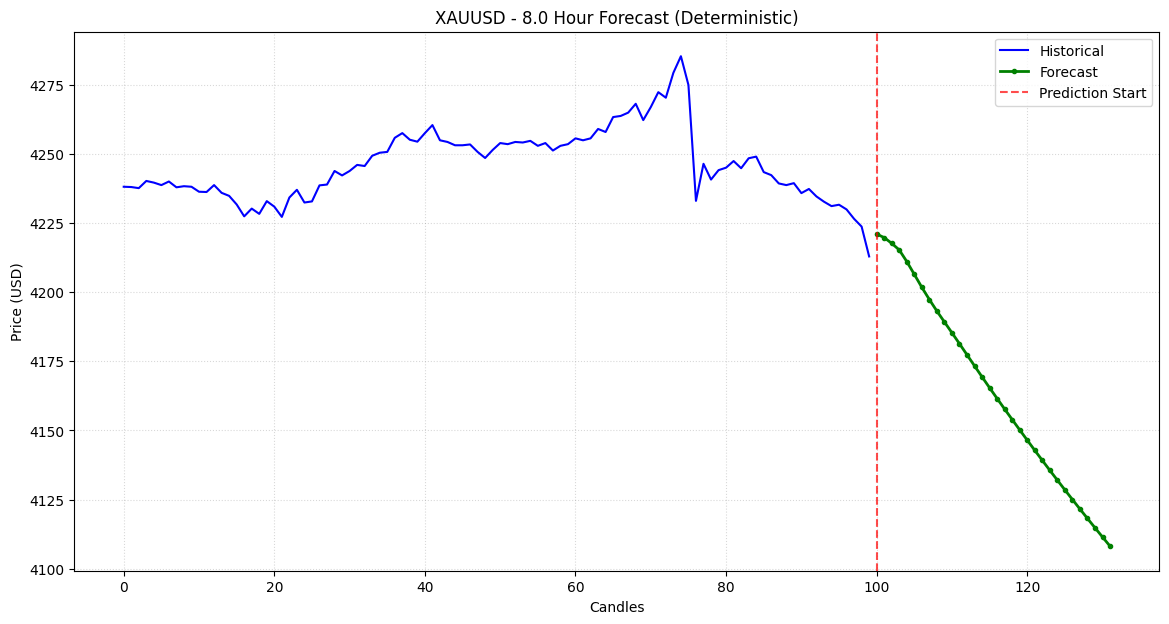


=== Prediction Summary ===
  Harga Terakhir: $4212.90
  Prediksi:       $4108.12
  Direction:      📉 TURUN
  Change:         $-104.78 (-2.49%)


In [39]:
# Forecast deterministik (tanpa random)
if TIMEFRAME == '15m':
    steps = FUTURE_HOURS * 4
elif TIMEFRAME == '30m':
    steps = FUTURE_HOURS * 2
else:
    steps = FUTURE_HOURS

# Batasi steps
steps = min(steps, 32)
actual_hours = steps * 15 / 60

print(f"Predicting {steps} candles ({actual_hours:.1f} hours) - Deterministic")

# Ambil sequence terakhir
last_sequence = scaled_data[-look_back:].reshape(1, look_back, 1)

# Prediksi tanpa Monte Carlo (deterministik)
future_preds, lstm_preds, arima_preds = model.predict_future(last_sequence, steps)

# Inverse scale
future_prices = loader.inverse_transform(future_preds)

# History
history_length = 100
history_prices = loader.inverse_transform(scaled_data[-history_length:].reshape(-1, 1))

# Plot
plt.figure(figsize=(14, 7))
x_history = np.arange(history_length)
x_forecast = np.arange(history_length, history_length + steps)

plt.plot(x_history, history_prices, label='Historical', color='blue', linewidth=1.5)
plt.plot(x_forecast, future_prices, label='Forecast', color='green', linewidth=2, marker='.')
plt.axvline(x=history_length, color='red', linestyle='--', alpha=0.7, label='Prediction Start')

plt.title(f"{SYMBOL} - {actual_hours:.1f} Hour Forecast (Deterministic)")
plt.xlabel("Candles")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Summary
change = future_prices[-1,0] - history_prices[-1,0]
pct = (change / history_prices[-1,0]) * 100
direction = "📈 NAIK" if change > 0 else "📉 TURUN"

print(f"\n=== Prediction Summary ===")
print(f"  Harga Terakhir: ${history_prices[-1,0]:.2f}")
print(f"  Prediksi:       ${future_prices[-1,0]:.2f}")
print(f"  Direction:      {direction}")
print(f"  Change:         ${change:.2f} ({pct:.2f}%)")